In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Add, Activation, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import pickle

In [4]:
base_dir = 'data'  
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [6]:
def build_baseline():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def build_resnet_like():
    inputs = Input(shape=(64, 64, 3))
    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)

    for _ in range(3):
        shortcut = x
        x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [8]:
def build_transfer():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
baseline = build_baseline()
history1 = baseline.fit(train_data, validation_data=val_data, epochs=5)

c:\Users\kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.7118 - loss: 1.5412 - val_accuracy: 0.6319 - val_loss: 0.5578
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.7825 - loss: 0.4481 - val_accuracy: 0.7704 - val_loss: 0.5009
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.7896 - loss: 0.4202 - val_accuracy: 0.7173 - val_loss: 0.5224
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8009 - loss: 0.4109 - val_accuracy: 0.7514 - val_loss: 0.5318
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8081 - loss: 0.3930 - val_accuracy: 0.7647 - val_loss: 0.5100


In [10]:
resnet_like = build_resnet_like()
history2 = resnet_like.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 530ms/step - accuracy: 0.7758 - loss: 0.5046 - val_accuracy: 0.5939 - val_loss: 0.6662
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.8052 - loss: 0.3998 - val_accuracy: 0.6717 - val_loss: 0.5520
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 508ms/step - accuracy: 0.8076 - loss: 0.3866 - val_accuracy: 0.7002 - val_loss: 0.5410
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.8199 - loss: 0.3717 - val_accuracy: 0.7343 - val_loss: 0.5003
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step - accuracy: 0.8133 - loss: 0.3629 - val_accuracy: 0.7685 - val_loss: 0.4801


In [11]:
transfer_model = build_transfer()
history3 = transfer_model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.7085 - loss: 0.8817 - val_accuracy: 0.7761 - val_loss: 0.5250
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.7877 - loss: 0.5402 - val_accuracy: 0.8008 - val_loss: 0.4468
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.8161 - loss: 0.4764 - val_accuracy: 0.7970 - val_loss: 0.4438
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.8303 - loss: 0.4128 - val_accuracy: 0.8273 - val_loss: 0.4106
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.8261 - loss: 0.4057 - val_accuracy: 0.8311 - val_loss: 0.3942


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step

===== Baseline CNN Confusion Matrix =====


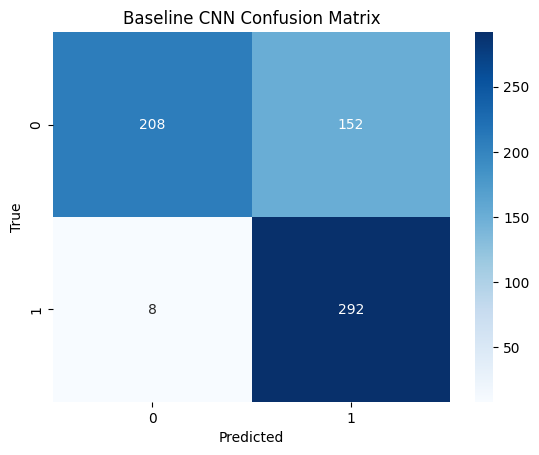

              precision    recall  f1-score   support

      benign       0.96      0.58      0.72       360
   malignant       0.66      0.97      0.78       300

    accuracy                           0.76       660
   macro avg       0.81      0.78      0.75       660
weighted avg       0.82      0.76      0.75       660

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step

===== ResNet-like Confusion Matrix =====


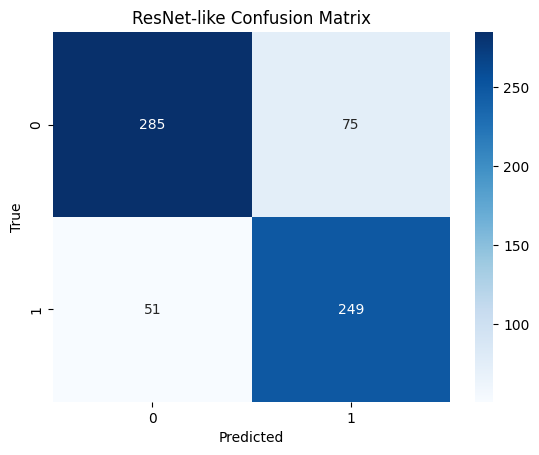

              precision    recall  f1-score   support

      benign       0.85      0.79      0.82       360
   malignant       0.77      0.83      0.80       300

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step

===== Transfer Learning (ResNet50) Confusion Matrix =====


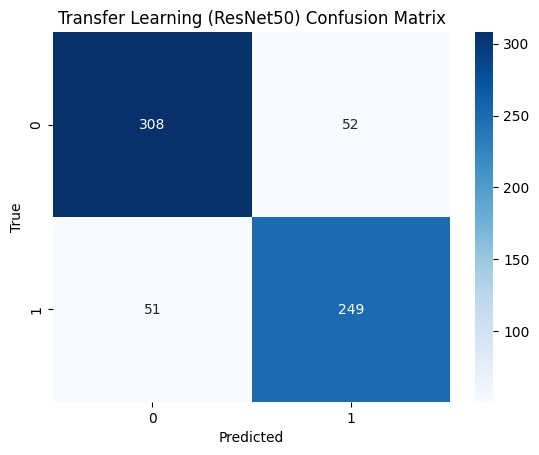

              precision    recall  f1-score   support

      benign       0.86      0.86      0.86       360
   malignant       0.83      0.83      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



In [12]:
def evaluate_model(model, test_data, name):
    y_pred = (model.predict(test_data) > 0.5).astype("int32")
    y_true = test_data.classes
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys()))

    print(f"\n===== {name} Confusion Matrix =====")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(cr)

evaluate_model(baseline, test_data, "Baseline CNN")
evaluate_model(resnet_like, test_data, "ResNet-like")
evaluate_model(transfer_model, test_data, "Transfer Learning (ResNet50)")

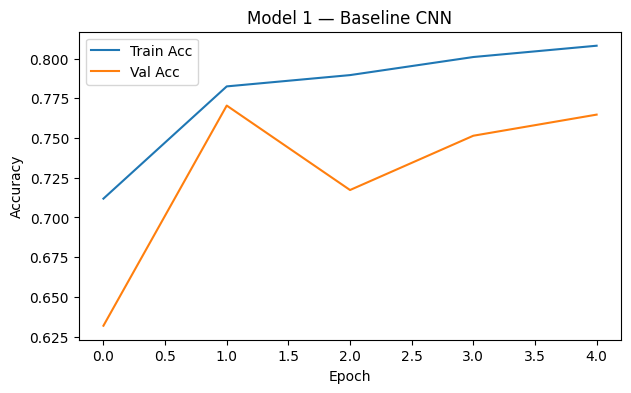

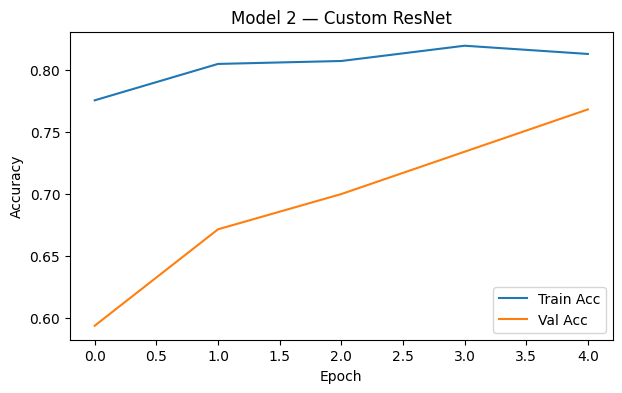

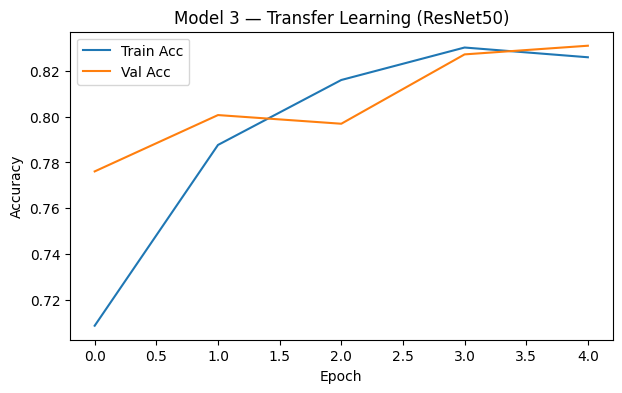

In [13]:
def plot_history(history, title):
    plt.figure(figsize=(7,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history1, "Model 1 — Baseline CNN")
plot_history(history2, "Model 2 — Custom ResNet")
plot_history(history3, "Model 3 — Transfer Learning (ResNet50)")

In [14]:
def get_gradcam(model, img_array, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    return cam

In [15]:
sample_img, _ = next(test_data)
img = sample_img[0:1]

last_conv_layer = 'conv5_block3_out'
cam = get_gradcam(transfer_model, img, last_conv_layer)

c:\Users\kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_43']]
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43442744..0.44439214].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43442744..0.44439214].


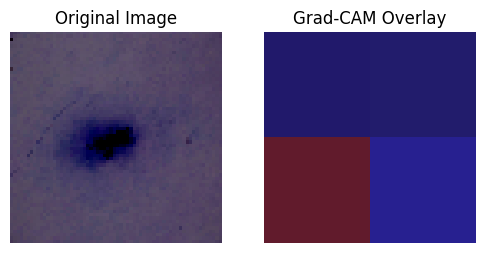

In [16]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img[0] / 255.0)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img[0] / 255.0)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()

In [17]:
transfer_model.save('model_resnet_final.h5')